<a href="https://colab.research.google.com/github/xavieralacoque/0-CODE/blob/main/RECHERCHE_BIBLIO_knowledge_graph_builder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Graph Builder

Explore Wikipedia to create knowledge graphs around specific terms of interest.

This notebook is explained in the article: XXX.

If you're not interested in how it works, simply run the notebook, jump to the button and then use the function simplified_plot() to create your own plots. There is an example to see what sort of input to give.

## Setup

Download and import required packages.

In [ ]:
#@title
!pip install wikipedia
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title
# Data manipulation
import pandas as pd
import random

# Wikipedia API
import wikipedia as wp
from wikipedia.exceptions import DisambiguationError, PageError

# Plotting
import networkx as nx
import matplotlib.pyplot as plt

## Explore

How do the results returned from Wikipedia look?

In [ ]:
print(wp.summary("data science")[:100])

Data science is an interdisciplinary field that uses scientific methods, processes, algorithms and s


In [ ]:
wp.page("data science").links[:5]

['Academic discipline',
 'Algorithm',
 'American Statistical Association',
 'Analysis',
 'Analytics']

## Define Knowledge Base Class

To build the knowledge graph, we'll create a class which stores all the information thit has learned, and has methods for searching and summarising.

In [ ]:
#@title
class RelationshipGenerator():
    """Generates relationships between terms, based on wikipedia links"""
    def __init__(self):
        """Links are directional, start + end, they should also have a weight"""
        self.links = [] # [start, end, weight]

    def scan(self, start=None, repeat=0):
        """Start scanning from a specific word, or from internal database
        
        Args:
            start (str): the term to start searching from, can be None to let
                algorithm decide where to start
            repeat (int): the number of times to repeat the scan
        """
        while repeat >= 0:

            # should check if start page exists
            # and haven't already scanned
            if start in [l[0] for l in self.links]:
                raise Exception("Already scanned")

            term_search = True if start is not None else False

            # If a start isn't defined, we should find one
            if start is None: 
                start = self.find_starting_point()

            # Scan the starting point specified for links
            print(f"Scanning page {start}...")
            try:
                # Fetch the page through the Wikipedia API
                page = wp.page(start)
                links = list(set(page.links))
                # ignore some uninteresting terms
                links = [l for l in links if not self.ignore_term(l)]

                # Add links to database
                link_weights = []
                for link in links:
                    weight = self.weight_link(page, link)
                    link_weights.append(weight)
                
                link_weights = [w / max(link_weights) for w in link_weights]

                for i, link in enumerate(links):
                    self.links.append([start, link.lower(), link_weights[i] + 2 * int(term_search)]) # 3 works pretty well

                # Print some data to the user on progress
                explored_nodes = set([l[0] for l in self.links])
                explored_nodes_count = len(explored_nodes)
                total_nodes = set([l[1] for l in self.links])
                total_nodes_count = len(total_nodes)
                new_nodes = [l.lower() for l in links if l not in total_nodes]
                new_nodes_count = len(new_nodes)
                print(f"New nodes added: {new_nodes_count}, Total Nodes: {total_nodes_count}, Explored Nodes: {explored_nodes_count}")

            except (DisambiguationError, PageError):
                # This happens if the page has disambiguation or doesn't exist
                # We just ignore the page for now, could improve this
                self.links.append([start, "DISAMBIGUATION", 0])

            repeat -= 1
            start = None
        
    def find_starting_point(self):
        """Find the best place to start when no input is given"""
        # Need some links to work with.
        if len(self.links) == 0:
            raise Exception("Unable to start, no start defined or existing links")
                
        # Get top terms
        res = self.rank_terms()
        sorted_links = list(zip(res.index, res.values))
        all_starts = set([l[0] for l in self.links])

        # Remove identifiers (these are on many Wikipedia pages)
        all_starts = [l for l in all_starts if '(identifier)' not in l]
        
        # print(sorted_links[:10])
        # Iterate over the top links, until we find a new one
        for i in range(len(sorted_links)):
            if sorted_links[i][0] not in all_starts and len(sorted_links[i][0]) > 0:
                return sorted_links[i][0]
        
        # no link found
        raise Exception("No starting point found within links")
        return

    @staticmethod
    def weight_link(page, link):
        """Weight an outgoing link for a given source page
        
        Args:
            page (obj): 
            link (str): the outgoing link of interest
        
        Returns:
            (float): the weight, between 0 and 1
        """
        weight = 0.1
        
        link_counts = page.content.lower().count(link.lower())
        weight += link_counts
        
        if link.lower() in page.summary.lower():
            weight += 3
        
        return weight


    def get_database(self):
        return sorted(self.links, key=lambda x: -x[2])


    def rank_terms(self, with_start=False):
        # We can use graph theory here!
        # tws = [l[1:] for l in self.links]
        df = pd.DataFrame(self.links, columns=["start", "end", "weight"])
        
        if with_start:
            df = df.append(df.rename(columns={"end": "start", "start":"end"}))
        
        return df.groupby("end").weight.sum().sort_values(ascending=False)
    
    def get_key_terms(self, n=20):
        return "'" + "', '".join([t for t in self.rank_terms().head(n).index.tolist() if "(identifier)" not in t]) + "'"

    @staticmethod
    def ignore_term(term):
        """List of terms to ignore"""
        if "(identifier)" in term or term == "doi":
            return True
        return False

We'll also define a function to simplify a graph which has many nodes. This will be handy for making plots. (Note that networkx has its own function for this, but we choose to right our own to have more control.)

In [ ]:
#@title
def simplify_graph(rg, max_nodes=1000):
    """Simplify a graph which has many nodes
    
    Remove items with low total weights
    This is an alterantive to restricted_view in networkx.
    
    Args:
        rg (RelationshipGenerator): object containing knowledge graph
        max_nodes (float): the number of nodes to search, or percentage of nodes
            to keep
    
    Returns:
        (RelationshipGenerator): simplified knowledge graph
    """
    # Get most interesting terms.
    nodes = rg.rank_terms()

    # Get nodes to keep
    if max_nodes >= 1:
        keep_nodes = nodes.head(max_nodes).index.tolist()
    elif max_nodes >= 0:
        keep_nodes = nodes.head(int(max_nodes * len(nodes))).index.tolist()
    
    # Filter list of nodes so that there are no nodes outside those of interest
    filtered_links = list(filter(lambda x: x[1] in keep_nodes, rg.links))
    filtered_links = list(filter(lambda x: x[0] in keep_nodes, filtered_links))

    # Define a new object and define its dictionary
    ac = RelationshipGenerator()
    ac.links = filtered_links

    return ac

## Build Knowledge Graph

Now we can build knowledge graphs for fields we're interested in.

In [ ]:
rg = RelationshipGenerator()
rg.scan("data science")
rg.scan("data analysis")
rg.scan("artificial intelligence")
rg.scan("machine learning")

Scanning page data science...
New nodes added: 116, Total Nodes: 116, Explored Nodes: 1
Scanning page data analysis...
New nodes added: 257, Total Nodes: 318, Explored Nodes: 2
Scanning page artificial intelligence...
New nodes added: 1466, Total Nodes: 1760, Explored Nodes: 3
Scanning page machine learning...


In [ ]:
rg.scan(repeat=10)

Scanning page data...


/usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Scanning page statistics...
New nodes added: 737, Total Nodes: 2365, Explored Nodes: 6
Scanning page data mining...
Scanning page big data...
New nodes added: 292, Total Nodes: 2596, Explored Nodes: 8
Scanning page database...
New nodes added: 741, Total Nodes: 3116, Explored Nodes: 9
Scanning page computational science...
New nodes added: 276, Total Nodes: 3236, Explored Nodes: 10
Scanning page data augmentation...
New nodes added: 246, Total Nodes: 3306, Explored Nodes: 11
Scanning page algorithm...
New nodes added: 494, Total Nodes: 3689, Explored Nodes: 12
Scanning page computer science...
New nodes added: 532, Total Nodes: 3916, Explored Nodes: 13
Scanning page data fusion...
New nodes added: 83, Total Nodes: 3947, Explored Nodes: 14
Scanning page data integration...
New nodes added: 148, Total Nodes: 4023, Explored Nodes: 15


We can check the top terms returned, and see how big the current graph is.

In [ ]:
print(f"The graph has {rg.rank_terms().shape[0]} terms and {len(rg.links)} connections.\n\n")

rg.rank_terms().head(10)

The graph has 4023 terms and 5393 connections.




end
data                     10.572015
data analysis             8.084295
database                  7.871329
machine learning          7.370572
statistics                6.432802
data mining               6.265534
big data                  6.142258
computational science     6.052396
data augmentation         6.016635
algorithm                 5.516014
Name: weight, dtype: float64

## Visualise the Graph

With a graph built, we can now plot it.

In [ ]:
#@title
def remove_self_references(l):
    return [i for i in l if i[0]!=i[1]]

def add_focus_point(links, focus="on me", focus_factor=3):
    for i, link in enumerate(links):
        if not (focus in link[0] or focus in link[1]):
            links[i] = [link[0], link[1], link[2] / focus_factor]
        else:
            links[i] = [link[0], link[1], link[2] * focus_factor]

    return links

def create_graph(rg, focus=None):

    links = rg.links
    links = remove_self_references(links)
    if focus is not None:
        links = add_focus_point(links, focus)
    
    node_data = rg.rank_terms()
    nodes = node_data.index.tolist()
    node_weights = node_data.values.tolist()
    node_weights = [nw * 100 for nw in node_weights]
    nodelist = nodes


    G = nx.DiGraph() # MultiGraph()
 
    # G.add_node()
    G.add_nodes_from(nodes)

    # Add edges
    G.add_weighted_edges_from(links)
   
    pos = nx.spring_layout(G, k=1, seed=7)  # positions for all nodes - seed for reproducibility

    fig = plt.figure(figsize=(12,12))

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodelist,
        node_size=node_weights,
        node_color='lightblue',
        alpha=0.7
    )

    widths = nx.get_edge_attributes(G, 'weight')    
    nx.draw_networkx_edges(
        G, pos,
        edgelist = widths.keys(),
        width=list(widths.values()),
        edge_color='lightblue',
        alpha=0.6
    )

    nx.draw_networkx_labels(G, pos=pos,
                            labels=dict(zip(nodelist,nodelist)),
                            font_color='black')

    """nx.draw(
        G,
        nodelist=nodes,
        node_size=node_weights,
        with_labels=True,
    )
"""
    # plt.box(False)
    plt.show()

# create_graph(ng)

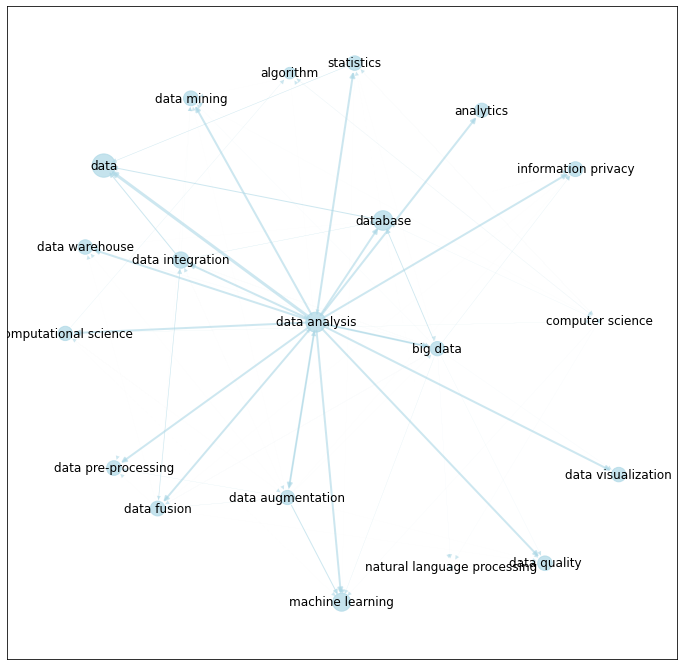

In [ ]:
ng = simplify_graph(rg, 20)

create_graph(ng)

We can see the output of the graph visualised, we've suceeded!

## Putting this all together

Now that we've shown each step, we can put this all together, to go directly from an input to a final graph.

In [ ]:
#@title
def simplified_plot(topics=["tests"], depth=20, max_size=20):

    rg = RelationshipGenerator()
    
    for topic in topics:
        rg.scan(topic)

    rg.scan(repeat=depth)

    print(f"Created {len(rg.links)} links with {rg.rank_terms().shape[0]} nodes.")

    ng = simplify_graph(rg, max_size)

    fig = create_graph(ng)

    plt.show()

    return rg

Scanning page biology...
New nodes added: 728, Total Nodes: 728, Explored Nodes: 1
Scanning page microbiology...
New nodes added: 579, Total Nodes: 1287, Explored Nodes: 2
Scanning page genetics...
Scanning page bacteria...
New nodes added: 1150, Total Nodes: 2200, Explored Nodes: 4
Scanning page life...
New nodes added: 910, Total Nodes: 3030, Explored Nodes: 5
Scanning page evolution...
New nodes added: 720, Total Nodes: 3727, Explored Nodes: 6
Scanning page virus...
New nodes added: 729, Total Nodes: 4358, Explored Nodes: 7
Scanning page archaea...
New nodes added: 489, Total Nodes: 4836, Explored Nodes: 8
Scanning page protist...
New nodes added: 615, Total Nodes: 5075, Explored Nodes: 9
Scanning page eukaryote...
New nodes added: 1720, Total Nodes: 6371, Explored Nodes: 10
Scanning page prokaryote...
New nodes added: 571, Total Nodes: 6597, Explored Nodes: 11
Scanning page fungus...
New nodes added: 1384, Total Nodes: 7304, Explored Nodes: 12
Scanning page ecology...
New nodes add

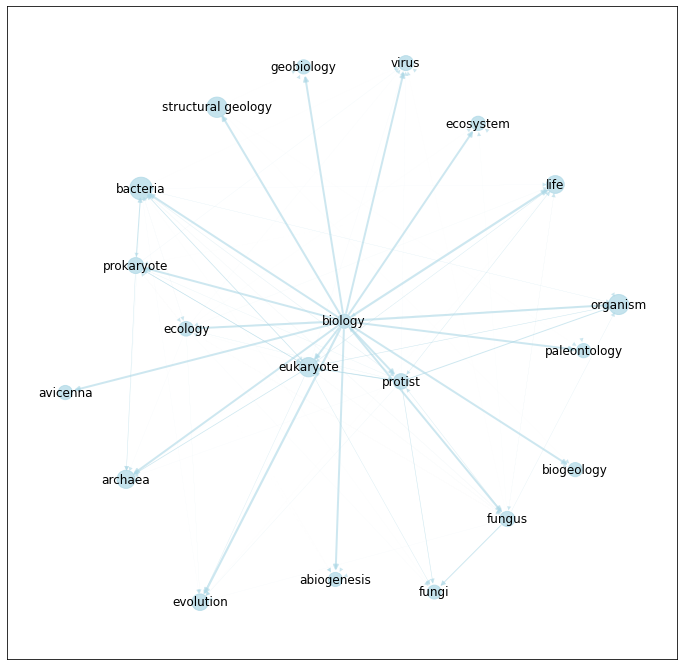

In [ ]:
tg = simplified_plot(topics=["biology", "microbiology", "genetics"], depth=10)